In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import os

# create a folder for the project
project_directory = 'drive/My Drive'
project_folder = 'Scan2BIM'

# if there is no such a folder yet, create one and change the directory to that folder
if not os.path.isdir('{}/{}'.format(project_directory, project_folder)):
    os.makedirs('{}/{}'.format(project_directory, project_folder))
os.chdir('{}/{}'.format(project_directory, project_folder))

# clone YOLOv5 from GitHub and change the directory
! git clone https://github.com/ultralytics/yolov5.git
os.chdir('yolov5') 

# install the required dependencies for YOLOv5
! pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 4.0 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 1.6 MB 60.7 MB/s 


In [3]:
import albumentations as A
import random
import string

# define augmentation operations for the random crops made of 2d floor plans
album_transforms = A.Compose([
            A.RandomCrop(640, 640),   # make a random crop of size 640 x 640 pxs (standard size used for training YOLOv5)
            A.RandomBrightnessContrast(p = 0.4, brightness_limit=0.25, contrast_limit=0.25),
            A.HorizontalFlip(p=0.5),
            A.OneOf([A.CLAHE(), A.RandomGamma()], p=1.0),
            A.ShiftScaleRotate(rotate_limit=5, scale_limit=0.2, shift_limit=0.1, p=0.9),
            A.OneOf([A.Blur(blur_limit=7, p=1.0), A.MotionBlur(), A.GaussNoise(), A.ImageCompression(quality_lower=90)], p=0.5),
            # A.CoarseDropout(max_holes=32, min_holes=None, max_height=16, max_width=16, fill_value=250, p=0.65),
        ], 
        bbox_params=A.BboxParams(format='coco', min_visibility=0.2, label_fields=['category_ids']))

# random id generator that will be used to name random crops before saving
def id_generator(size=6, chars=string.ascii_letters + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [4]:
import os
from pycocotools.coco import COCO

# download the annotated dataset from git repository
rootFolder = os.curdir
output = 'Scan2BIM_annotated'
if not os.path.isdir('{}/data/{}'.format(rootFolder, output)):
    ! wget https://github.com/skobeyev/shipping_container/blob/main/Scan2BIM_annotated.rar?raw=true -O data/Scan2BIM_annotated.rar
    ! unrar x data/Scan2BIM_annotated.rar data/
    ! rm data/Scan2BIM_annotated.rar

cocoDataset='instances_Train'
annFile='{}/data/{}/annotations/{}.json'.format(rootFolder, output, cocoDataset)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=1.67s)
creating index...
index created!


In [5]:
import os
from PIL import Image

# create folder for storing the dataset
dataset_folder = 'dataset_scan2bim'
dataset_path = {
    "train": '{}/data/{}/train'.format(rootFolder, dataset_folder),
    "valid": '{}/data/{}/valid'.format(rootFolder, dataset_folder),
    "test":  '{}/data/{}/test'.format(rootFolder, dataset_folder)
}

if not os.path.isdir('{}/data/{}'.format(rootFolder, dataset_folder)):
    for data_set in ["train", "valid", "test"]:
        os.makedirs('{}/images'.format(dataset_path[data_set]))
        os.makedirs('{}/labels'.format(dataset_path[data_set]))

    # create a yaml file with a description of the dataset
    with open('{}/data/{}/scan2bim.yaml'.format(rootFolder, dataset_folder), 'a') as file:
        file.write('# YOLOv5 🚀 custom dataset by Sultan and Jan, input data by Dr. Michael Kraus\n')
        file.write('# Dataset is first loaded in COCO format from CVAT and later converted to YOLO format after augmentations.\n')
        file.write('# Example usage: python train.py --data scan2bim.yaml\n')
        file.write('# parent\n# ├── yolov5\n#     └── {}\n\n\n'.format(dataset_folder))
        file.write('path: ../{}/scan2bim.yaml  # dataset root dir\n'.format(dataset_folder))
        file.write('train: {}/images  # train images, relative to ''path''\n'''.format(dataset_path["train"]))
        file.write('val: {}/images  # validation images\n'.format(dataset_path["valid"]))
        file.write('test: {}/images  # test images (optional)\n\n# Classes\n'.format(dataset_path["test"]))
        file.write('names:\n')
        for yy in range(1, len(coco.cats) + 1):
            file.write('  {}: {}\n'.format((coco.cats[yy]["id"]-1), coco.cats[yy]["name"]))
    file.close()
else:
    print('A folder named {} already exists, could not create a new dataset.'.format(dataset_folder))

A folder named dataset_scan2bim already exists, could not create a new dataset.


In [6]:
categoryCount = {}
catName2catId = {}
tot = len(coco.anns)

for kk in range(1, len(coco.cats) + 1):
    categoryCount[coco.cats[kk]["name"]] = len(coco.catToImgs[kk]) / tot
    catName2catId[coco.cats[kk]["name"]] = coco.cats[kk]["id"]

categoryCount = {k: v for k, v in sorted(categoryCount.items(), key=lambda item: item[1])}
display(categoryCount)

{'Beam': 0.0005385029617662897,
 'Stairs': 0.011847065158858373,
 'Door': 0.031771674744211095,
 'Column': 0.045234248788368334,
 'Window': 0.22294022617124395,
 'Annotations': 0.27948303715670436,
 'Wall': 0.4081852450188476}

In [35]:
%matplotlib inline
from math import ceil
import skimage.io as io
import matplotlib.pyplot as plt
from math import ceil
from math import ceil

# specify the distribution of train, test, and validation sets and the total number of annotations to be sampled
dataset_distribution = {
    "train": 0.85,
    "valid": 0.15,
    "test": 0
}
total_img = 15000

ann_required_count = {"train": {}, "valid": {}, "test": {}}
ann_actual_count = {"train": {}, "valid": {}, "test": {}}
for data_set in ["train", "valid", "test"]:
    for myCat in categoryCount.keys():
        ann_required_count[data_set][myCat] = ceil(total_img * dataset_distribution[data_set] * categoryCount[myCat])
        ann_actual_count[data_set][myCat] = 0

for data_set in ["train", "valid", "test"]:
    for myCat in categoryCount.keys():
        search_img = list(set(coco.catToImgs[catName2catId[myCat]]))

        intermediate_max = ceil((ann_required_count[data_set][myCat] - ann_actual_count[data_set][myCat]) / len(search_img))
        for ii in search_img:
            img = io.imread('{}/data/{}/images/{}'.format(rootFolder, output, coco.loadImgs(ii)[0]["file_name"]))
            annIds = coco.getAnnIds(imgIds=coco.loadImgs(ii)[0]["id"], catIds=[], iscrowd=None)
            anns = coco.loadAnns(annIds)
            bboxes = []
            catIds = []
            class_labels = []
            
            for jj in range(len(anns)):
                bboxes.append(anns[jj]['bbox'])
                catIds.append(anns[jj]['category_id'])
                class_labels.append(coco.cats[anns[jj]['category_id']]['name'])

            intermediate_counter = 0
            while ann_actual_count[data_set][myCat] < ann_required_count[data_set][myCat] and intermediate_counter < intermediate_max:
                transformed = album_transforms(image=img, bboxes=bboxes, category_ids=catIds)

                if catName2catId[myCat] in transformed["category_ids"]:
                    # count the number of categories for a given image
                    intermediate_counter += transformed["category_ids"].count(catName2catId[myCat]) 

                    myFilename = '{}_{}'.format(coco.imgs[ii]["file_name"][:-4], id_generator())
                    # save the image
                    im = Image.fromarray(transformed["image"])
                    im.save('{}/images/{}.png'.format(dataset_path[data_set], myFilename))

                    # save the annotations as a txt file
                    for cat_ids_rec, bboxes_rec in zip(transformed["category_ids"], transformed['bboxes']):
                        with open('{}/labels/{}.txt'.format(dataset_path[data_set], myFilename), 'a') as file:
                            # some accounting work
                            ann_actual_count[data_set][coco.cats[cat_ids_rec]['name']] += 1
                            
                            # converting annotations from coco to yolo format
                            img_height = len(transformed["image"][0])
                            img_width = len(transformed["image"][1])

                            file.write('{} {} {} {} {}\n'.format(cat_ids_rec - 1, (bboxes_rec[0] + bboxes_rec[2]/2)/img_width, (bboxes_rec[1] + bboxes_rec[3]/2)/img_height, bboxes_rec[2]/img_width, bboxes_rec[3]/img_height))
                        file.close()
        display("Sampled sufficient amount of '{}' for the '{}' dataset.".format(myCat, data_set))

print('Dataset was successfully created.')

"Sampled sufficient amount of 'Beam' for the 'train' dataset."

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:2797: DecompressionBombWarning: Image size (175982961 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:2797: DecompressionBombWarning: Image size (152511282 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


"Sampled sufficient amount of 'Stairs' for the 'train' dataset."

"Sampled sufficient amount of 'Door' for the 'train' dataset."

"Sampled sufficient amount of 'Column' for the 'train' dataset."

"Sampled sufficient amount of 'Window' for the 'train' dataset."

"Sampled sufficient amount of 'Annotations' for the 'train' dataset."

"Sampled sufficient amount of 'Wall' for the 'train' dataset."

"Sampled sufficient amount of 'Beam' for the 'valid' dataset."

"Sampled sufficient amount of 'Stairs' for the 'valid' dataset."

"Sampled sufficient amount of 'Door' for the 'valid' dataset."

"Sampled sufficient amount of 'Column' for the 'valid' dataset."

"Sampled sufficient amount of 'Window' for the 'valid' dataset."

"Sampled sufficient amount of 'Annotations' for the 'valid' dataset."

"Sampled sufficient amount of 'Wall' for the 'valid' dataset."

"Sampled sufficient amount of 'Beam' for the 'test' dataset."

"Sampled sufficient amount of 'Stairs' for the 'test' dataset."

"Sampled sufficient amount of 'Door' for the 'test' dataset."

"Sampled sufficient amount of 'Column' for the 'test' dataset."

"Sampled sufficient amount of 'Window' for the 'test' dataset."

"Sampled sufficient amount of 'Annotations' for the 'test' dataset."

"Sampled sufficient amount of 'Wall' for the 'test' dataset."

Dataset was successfully created.


In [ ]:
'https://drive.google.com/file/d/1p0kDRz9HudA3ep-Qhzk2zLVIxPeki3wh/view?usp=sharing'

In [11]:
pretrained = True

if pretrained: # download weights of a pretrained scan2bim yolov5 model 
    ! wget https://github.com/skobeyev/shipping_container/blob/main/scan2bim_best.rar?raw=true -O models/scan2bim_best.rar
    ! unrar x models/scan2bim_best.rar models/
    ! rm models/scan2bim_best.rar
else:
    ! python train.py --data dataset_scan2bim/scan2bim.yaml --epochs 100 --weights '' --cfg yolov5m.yaml --batch-size 40

--2022-12-24 11:59:06--  https://github.com/skobeyev/shipping_container/blob/main/scan2bim_best.rar?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/skobeyev/shipping_container/raw/main/scan2bim_best.rar [following]
--2022-12-24 11:59:06--  https://github.com/skobeyev/shipping_container/raw/main/scan2bim_best.rar
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/skobeyev/shipping_container/main/scan2bim_best.rar [following]
--2022-12-24 11:59:07--  https://raw.githubusercontent.com/skobeyev/shipping_container/main/scan2bim_best.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443

Inference and Visualization

In [25]:
import cv2
import os

import pandas as pd
%matplotlib inline
import skimage.io as io
import matplotlib.pyplot as plt

# visualize and store each detected class in a separate image and save
def detected_classes(fileName, path, path_original_img):
    df = pd.read_csv('{}/labels/{}.txt'.format(path, fileName), delimiter = " ", header=None, names=["cat_id", "a", "b", "c", "d"])
    df['bbox'] = df.apply(lambda row: (row.a, row.b, row.c, row.d), axis=1)
    df = df.drop(columns=['a', 'b', 'c', 'd'])
    identified_classes = list(set(df["cat_id"].tolist()))

    for ii in range(len(identified_classes)):
        selected_cat = identified_classes[ii];

        bboxes = df[df.cat_id == selected_cat].bbox.tolist()
        class_names = [coco.cats[selected_cat + 1]["name"]] * len(bboxes)
        img = io.imread('{}/{}.png'.format(path_original_img, fileName))
        img = img[:, :, :3]

        img = visualize(img, bboxes, class_names)
        if not os.path.isdir('{}/classes'.format(path)):
            os.makedirs('{}/classes'.format(path))
        io.imsave('{}/classes/{}_{}.png'.format(path, fileName, coco.cats[selected_cat + 1]["name"]), img)

# visualizes all inputted bounding boxes
def visualize(image, bboxes, class_names):
    img = image.copy()
    for bbox, class_name in zip(bboxes, class_names):
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)
    return img

# visualizes a single bounding box on the image. NB: Annotations should be in YOLO format.
def visualize_bbox(img, bbox, class_name, thickness=2):
    BOX_COLOR = (255, 0, 0) # Red
    TEXT_COLOR = (255, 255, 255) # White
    color=BOX_COLOR

    x_cen, y_cen, w, h = bbox
    img_height = len(img[0])
    img_width = len(img[1])
    x_min, x_max, y_min, y_max = int((x_cen - w/2) * img_width), int((x_cen + w/2) * img_width), int((y_cen - h/2) * img_height), int((y_cen + h/2) * img_height)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.5, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

In [18]:
# download some excerpts from previously unseen floor plans
! wget https://github.com/skobeyev/shipping_container/blob/main/example_floor_plans.rar?raw=true -O example_floor_plans.rar
! unrar x example_floor_plans.rar example_floor_plans
! rm example_floor_plans.rar

--2022-12-24 12:11:58--  https://github.com/skobeyev/shipping_container/blob/main/example_floor_plans.rar?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/skobeyev/shipping_container/raw/main/example_floor_plans.rar [following]
--2022-12-24 12:11:59--  https://github.com/skobeyev/shipping_container/raw/main/example_floor_plans.rar
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/skobeyev/shipping_container/main/example_floor_plans.rar [following]
--2022-12-24 12:11:59--  https://raw.githubusercontent.com/skobeyev/shipping_container/main/example_floor_plans.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercon

In [19]:
! python detect.py --weights models/scan2bim_best.pt --source example_floor_plans/crop_ul.png --save-txt

detect: weights=['models/scan2bim_best.pt'], source=example_floor_plans/crop_ul.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-47-g2370a55 Python-3.8.16 torch-1.13.0+cu116 CPU

Fusing layers... 
YOLOv5m summary: 212 layers, 20877180 parameters, 0 gradients, 47.9 GFLOPs
image 1/1 /content/drive/MyDrive/Scan2BIM/yolov5/example_floor_plans/crop_ul.png: 640x640 19 Walls, 5 Windows, 1 Column, 3 Annotationss, 1116.5ms
Speed: 4.2ms pre-process, 1116.5ms inference, 19.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp
1 labels saved to runs/detect/exp/labels


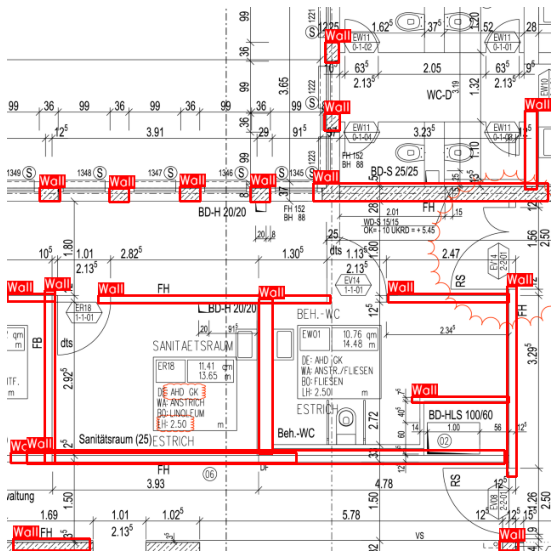

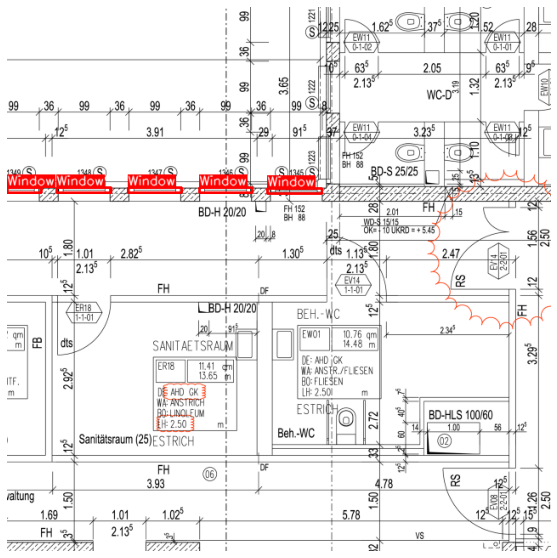

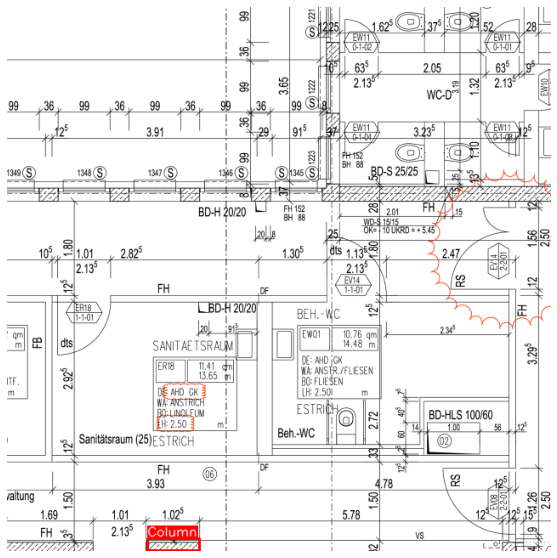

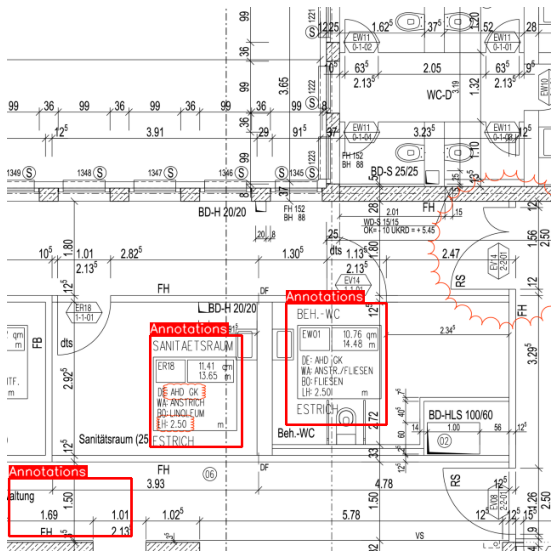

In [26]:
fileName = "crop_ul"
detected_forlder = "runs/detect/exp"
original_img_folder = "example_floor_plans"

detected_classes(fileName, detected_forlder, original_img_folder)